1. **Environment Setup**

Importing necessary libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and machine learning (Prophet, Scikit-Learn). Defining file paths for input data.

In [22]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Configuration ---
ZIP_FILE_PATH = "Aadhar Dataset Hackathon.zip"
EXTRACT_DIR = "aadhaar_data_extracted"

# Ensure charts look good
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

2. **Data Extraction**

This utility function handles the extraction of the provided ZIP file and automatically identifies the folder paths for Enrolment, Biometric, and Demographic datasets.

In [23]:
def extract_and_find_paths(zip_path, extract_to):
    """
    Extracts zip file and dynamically finds relevant data folders.
    """
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"✅ Extracted to {extract_to}")
    else:
        print(f"ℹ️ Directory {extract_to} already exists. Skipping extraction.")

    # Search for folders containing specific keywords
    paths = {}
    for root, dirs, files in os.walk(extract_to):
        for d in dirs:
            lower_d = d.lower()
            if "enrol" in lower_d:
                paths['enrol'] = os.path.join(root, d)
            elif "bio" in lower_d:
                paths['bio'] = os.path.join(root, d)
            elif "demo" in lower_d:
                paths['demo'] = os.path.join(root, d)

    if len(paths) < 3:
        print("⚠️ Warning: Could not auto-detect all 3 folders. Please check the zip structure.")

    return paths

3. **Data Cleaning and Preprocessing**

This step loads all CSV files from a directory, merges them into a single DataFrame, and applies standard cleaning operations:

Standardizing column names.

Parsing dates.

Handling missing values (dropping critical missing rows, filling numeric NaNs with 0).

Creating a total column for aggregated metrics.

In [24]:
def load_and_clean_data(folder_path, data_type):
    """
    Loads all CSVs from a folder and performs cleaning and preprocessing.
    data_type: 'enrol', 'bio', or 'demo'
    """
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not all_files:
        print(f"❌ No files found in {folder_path}")
        return pd.DataFrame()

    print(f"DTO Loading {len(all_files)} files for {data_type}...")

    # Load and concatenate all CSVs
    df_list = (pd.read_csv(f) for f in all_files)
    df = pd.concat(df_list, ignore_index=True)

    # 1. Standardize Column Names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # 2. Rename Inconsistent Columns
    rename_map = {
        'age_18_greater': 'age_18plus',
        'bio_age_17_': 'bio_age_17plus',
        'demo_age_17_': 'demo_age_17plus'
    }
    df.rename(columns=rename_map, inplace=True)

    # 3. Parse Dates
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

    # 4. Handle Missing Data
    df.dropna(subset=['date', 'state', 'district'], inplace=True)

    # Text Cleaning
    for col in ['state', 'district']:
        df[col] = df[col].astype(str).str.strip().str.title()

    # State Name Standardization
    df['state'] = df['state'].replace({'Jammu And Kashmir': 'Jammu & Kashmir'})

    # Fill numeric NaNs with 0
    num_cols = df.select_dtypes(include='number').columns
    df[num_cols] = df[num_cols].fillna(0)

    # 5. Feature Engineering: Calculate Totals
    if data_type == 'enrol':
        df['total'] = df['age_0_5'] + df['age_5_17'] + df['age_18plus']
    elif data_type == 'bio':
        df['total'] = df['bio_age_5_17'] + df['bio_age_17plus']
    elif data_type == 'demo':
        df['total'] = df['demo_age_5_17'] + df['demo_age_17plus']

    return df

4. **State Classification and Trend Analysis**

State Classification: Categorizes states based on the volume of Enrolment vs. Updates (Biometric/Demographic) to recommend specific operational strategies (e.g., "Growth Phase" vs "Maintenance Phase").

Visualization: Plots the comparative monthly trends of all three services.

In [25]:
def classify_states(enrol, bio, demo):
    """
    Classifies states based on the dominance of Enrolment vs Updates.
    """
    state_enrol = enrol.groupby('state')['total'].sum().rename('Enrolment')
    state_bio = bio.groupby('state')['total'].sum().rename('Biometric')
    state_demo = demo.groupby('state')['total'].sum().rename('Demographic')

    merged = pd.concat([state_enrol, state_bio, state_demo], axis=1).fillna(0)

    def get_order(row):
        # Returns ordering string like "E>B>D"
        return ">".join(row.sort_values(ascending=False).index.str[0])

    merged['ordering'] = merged.apply(get_order, axis=1)

    recom_map = {
        'E>B>D': 'High New Enrolments (Growth Phase)',
        'B>D>E': 'High Bio Updates (Maintenance Phase)',
        'D>B>E': 'High Demo Updates (Correction Phase)',
        'B>E>D': 'Bio Updates Exceed Enrolments',
    }
    merged['recommendation'] = merged['ordering'].map(recom_map).fillna('Analyze Deeply')
    return merged

In [26]:
def plot_comparative_trends(enrol, bio, demo):
    """
    Plots monthly trends for Enrolment, Biometric, and Demographic updates.
    """
    plt.figure(figsize=(14, 7))

    # Resample by Month End ('ME')
    e_trend = enrol.groupby(pd.Grouper(key='date', freq='ME'))['total'].sum()
    b_trend = bio.groupby(pd.Grouper(key='date', freq='ME'))['total'].sum()
    d_trend = demo.groupby(pd.Grouper(key='date', freq='ME'))['total'].sum()

    plt.plot(e_trend, label='New Enrolments', color='#1f77b4', linewidth=2)
    plt.plot(b_trend, label='Biometric Updates', color='#ff7f0e', linewidth=2, linestyle='--')
    plt.plot(d_trend, label='Demographic Updates', color='#2ca02c', linewidth=2, linestyle='-.')

    plt.title('National Trend: Enrolment vs Updates', fontsize=16)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

5. Data Preparation for Time Series Forecasting

Before building the model, we must aggregate the data to the appropriate time frequency.

Aggregation: We group the enrolment data by date to get the total daily or monthly volume.

Renaming: The Prophet library requires specific column names: ds for the date column and y for the target value (Enrolment count).

Visual Inspection: We plot the raw time series to identify any obvious outliers or gaps before training.

In [27]:
def forecast_prophet(df, date_col='date', value_col='total', periods=6):
    """
    Aggregates data monthly and forecasts using Prophet.
    """
    # 1. Prepare Data for Prophet
    df_monthly = df.groupby(pd.Grouper(key=date_col, freq='ME'))[value_col].sum().reset_index()
    df_monthly.columns = ['ds', 'y']

    # 2. Train/Test Split
    train = df_monthly.iloc[:-3]
    test = df_monthly.iloc[-3:]

    # 3. Model Training
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.add_country_holidays(country_name='IN')
    model.fit(train)

    # 4. Future Prediction
    future = model.make_future_dataframe(periods=periods + 3, freq='M')
    forecast = model.predict(future)

    # 5. Validation Metrics
    y_true = test['y'].values
    y_pred = forecast.iloc[-3-periods:-periods]['yhat'].values

    if len(y_true) > 0 and len(y_pred) > 0:
        min_len = min(len(y_true), len(y_pred))
        mae = mean_absolute_error(y_true[:min_len], y_pred[:min_len])
        print(f"📉 Model MAE (Validation): {mae:.2f}")

    # 6. Visualization
    model.plot(forecast)
    plt.title(f"Forecast for {value_col}")
    plt.show()

    return forecast

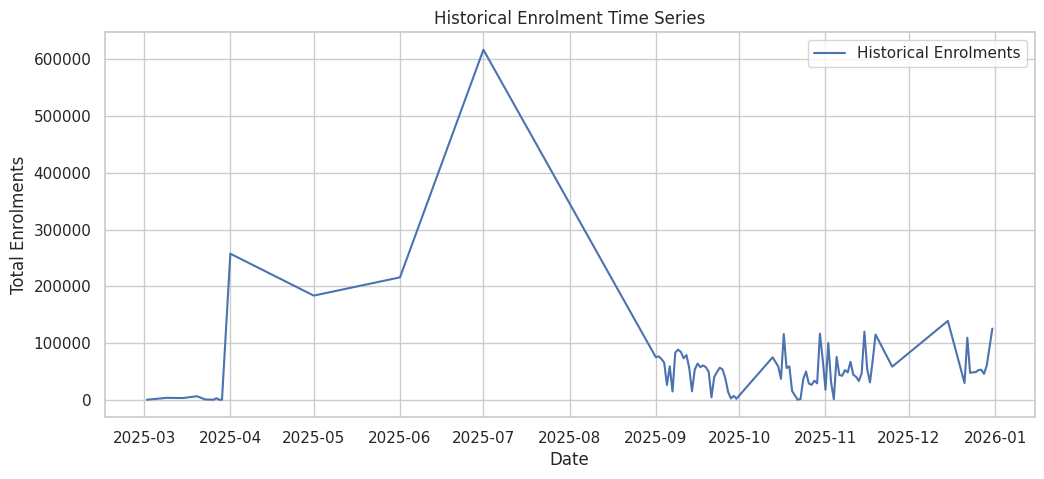

Prepared 92 data points for modeling.


In [28]:
# Aggregate data by date
# Note: If your data is daily, this keeps it daily. If it's sparse, you might want to resample.
df_forecast = enrol_df.groupby('date')['total'].sum().reset_index()

# Rename columns for Prophet (strict requirement: 'ds' and 'y')
df_forecast.columns = ['ds', 'y']

# Quick visualization of the data to be modeled
plt.figure(figsize=(12, 5))
plt.plot(df_forecast['ds'], df_forecast['y'], label='Historical Enrolments')
plt.title('Historical Enrolment Time Series')
plt.xlabel('Date')
plt.ylabel('Total Enrolments')
plt.legend()
plt.show()

print(f"Prepared {len(df_forecast)} data points for modeling.")

6. Model Building (Facebook Prophet)

We utilize Facebook Prophet, an additive regression model, for forecasting.

Seasonality: We enable yearly seasonality to capture annual trends (e.g., spikes during specific months).

Holidays: We add standard Indian holidays (add_country_holidays) as these often impact enrolment center operations.

Training: The model is fitted on the historical dataset prepared in the previous step.

In [29]:
# Initialize the Prophet model
# We enable yearly seasonality as Aadhaar enrolments often follow annual cycles
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False)

# Add Indian Holidays to account for operational closures
model.add_country_holidays(country_name='IN')

# Train the model
print("Training the Prophet model...")
model.fit(df_forecast)
print("✅ Model training complete.")

Training the Prophet model...


/usr/local/lib/python3.12/dist-packages/holidays/countries/india.py:190: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)


✅ Model training complete.


7. Model Evaluation and Diagnostic Analysis

To trust our forecast, we must measure the model's accuracy using Cross-Validation.

Metric - MAE (Mean Absolute Error): Represents the average absolute difference between predicted and actual values. Lower is better.

Metric - RMSE (Root Mean Squared Error): Penalizes larger errors more significantly.

Backtesting: We simulate a historical forecast (e.g., hiding the last 6 months of data) to see how well the model would have performed.

INFO:prophet:Making 4 forecasts with cutoffs between 2025-09-02 00:00:00 and 2025-12-01 00:00:00


Running cross-validation to evaluate accuracy...


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 11.



--- Model Performance Metrics ---
horizon    17 days 00:00:00
mae          2575273.526364
rmse          3035303.67026
mape             313.512067
dtype: object


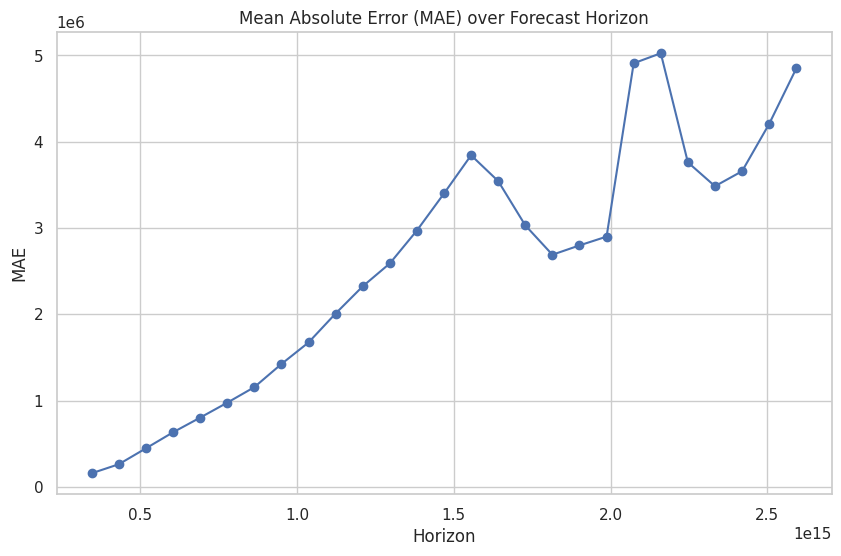

In [31]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform Cross-Validation (Backtesting)
# initial: training data size, period: spacing between cutoffs, horizon: forecast range
print("Running cross-validation to evaluate accuracy...")
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='30 days')

# Calculate Performance Metrics
df_p = performance_metrics(df_cv)

# Display the average metrics
print("\n--- Model Performance Metrics ---")
print(df_p[['horizon', 'mae', 'rmse', 'mape']].mean())

# Visualizing the error
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['mae'], marker='o')
plt.title('Mean Absolute Error (MAE) over Forecast Horizon')
plt.xlabel('Horizon')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

8. Final Forecast: Next 12 Weeks

We generate the future trajectory for Aadhaar enrolments.

Horizon: Forecasting the next 12 weeks.

Output: The plot below shows the predicted values (dark line) along with the uncertainty intervals (shaded blue area), representing the best-case and worst-case scenarios.

--- 12-Week Enrolment Forecast ---
            ds          yhat    yhat_lower    yhat_upper
92  2026-01-04  2.300369e+05  2.015569e+05  2.582394e+05
93  2026-01-11  6.460965e+05  6.169508e+05  6.765603e+05
94  2026-01-18  1.212882e+06  1.181949e+06  1.243840e+06
95  2026-01-25  1.760507e+06  1.730300e+06  1.789047e+06
96  2026-02-01  2.100185e+06  2.069332e+06  2.129708e+06
97  2026-02-08  2.096162e+06  2.066099e+06  2.125993e+06
98  2026-02-15  1.756782e+06  1.727889e+06  1.787340e+06
99  2026-02-22  1.283728e+06  1.251415e+06  1.312544e+06
100 2026-03-01  9.603454e+05  9.297972e+05  9.905427e+05
101 2026-03-08  9.041555e+05  8.748276e+05  9.344800e+05
102 2026-03-15  9.513118e+05  9.220351e+05  9.833282e+05
103 2026-03-22  9.069233e+05  8.777138e+05  9.388876e+05


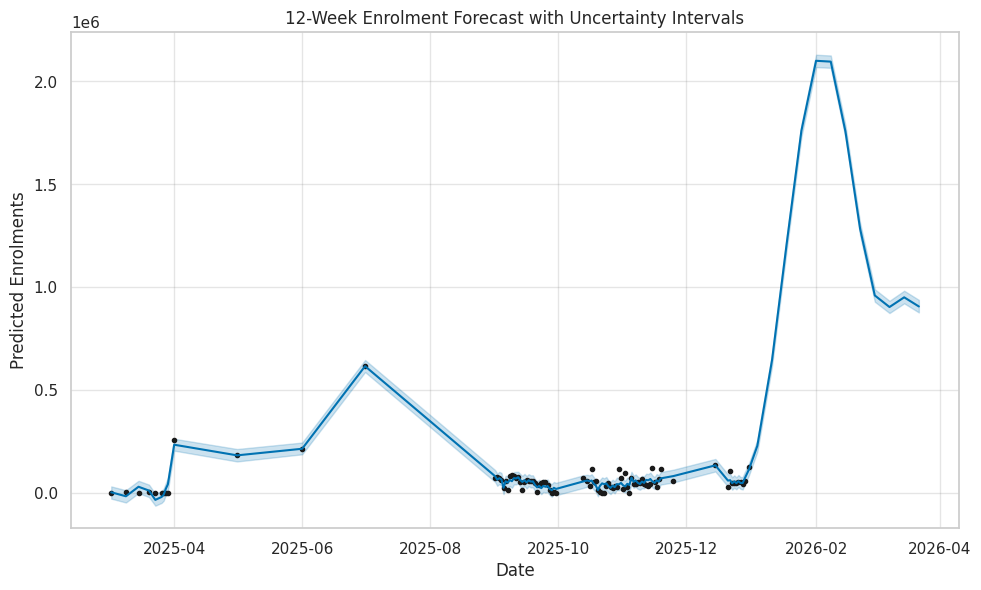

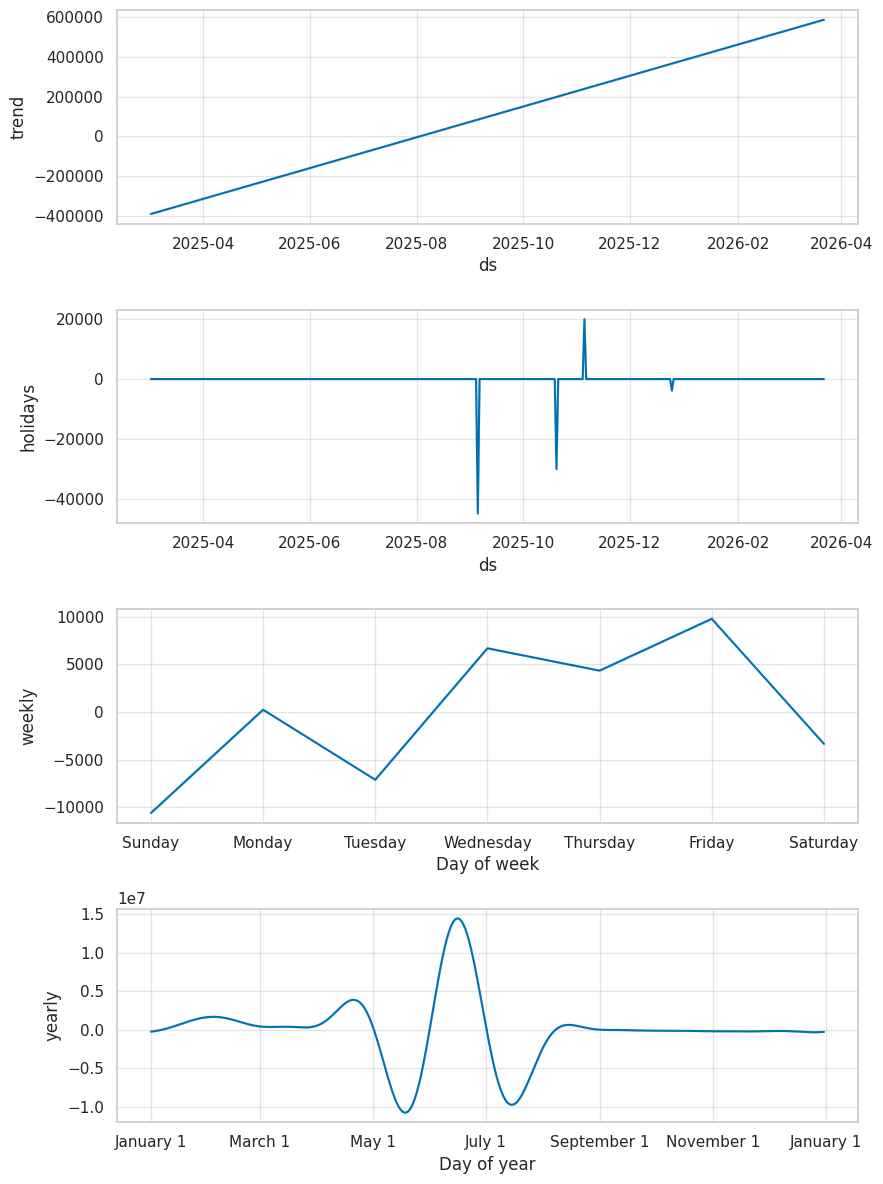

In [32]:
# Create a dataframe for future dates (Next 12 Weeks)
# freq='W' ensures we get weekly predictions
future = model.make_future_dataframe(periods=12, freq='W')

# Predict
forecast = model.predict(future)

# Filter just the future predictions for display
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

print("--- 12-Week Enrolment Forecast ---")
print(future_forecast)

# Plotting the specific forecast
fig1 = model.plot(forecast)
plt.title('12-Week Enrolment Forecast with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Predicted Enrolments')
plt.show()

# Optional: Decomposition (Trend vs Weekly vs Yearly patterns)
fig2 = model.plot_components(forecast)
plt.show()

9. **Pipeline Execution**

-> Running the full pipeline

-> Extract data.

-> Load and clean all datasets.

-> Perform classification analysis.

-> Visualize trends.

-> Generate forecasts.



🚀 Starting Analysis Pipeline...
ℹ️ Directory aadhaar_data_extracted already exists. Skipping extraction.
DTO Loading 3 files for enrol...
DTO Loading 4 files for bio...
DTO Loading 5 files for demo...

🗺️ Classifying States...
Top 5 States by Activity:
                              Enrolment  Biometric  Demographic ordering  \
state                                                                     
100000                           218.0        0.0          2.0    E>D>B   
Andaman & Nicobar Islands        114.0     2384.0       1059.0    B>D>E   
Andaman And Nicobar Islands      397.0    18314.0       6187.0    B>D>E   
Andhra Pradesh                127686.0  3714633.0    2295582.0    B>D>E   
Arunachal Pradesh               4344.0    72394.0      36443.0    B>D>E   

                                                   recommendation  
state                                                              
100000                                             Analyze Deeply  
Andaman & Nicoba

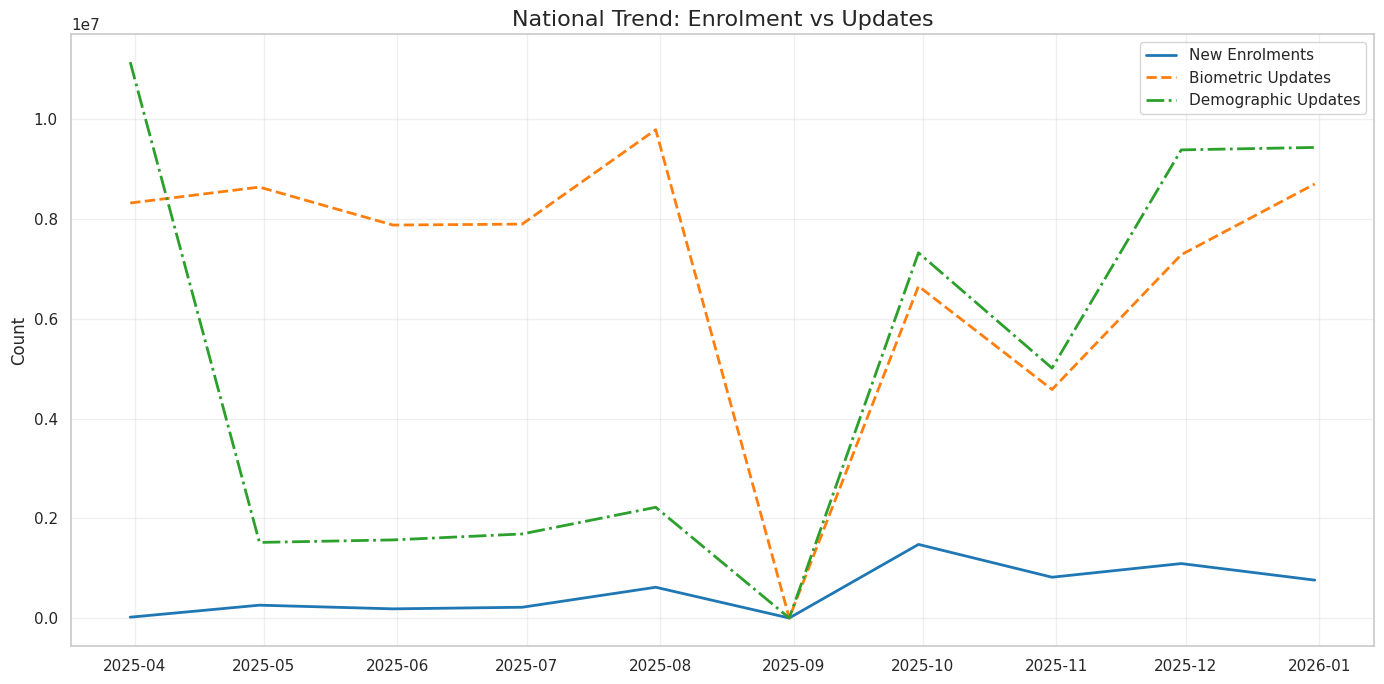


🔮 Running Forecast for Enrolment...


/usr/local/lib/python3.12/dist-packages/holidays/countries/india.py:190: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
INFO:prophet:n_changepoints greater than number of observations. Using 4.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


📉 Model MAE (Validation): 6328841.84


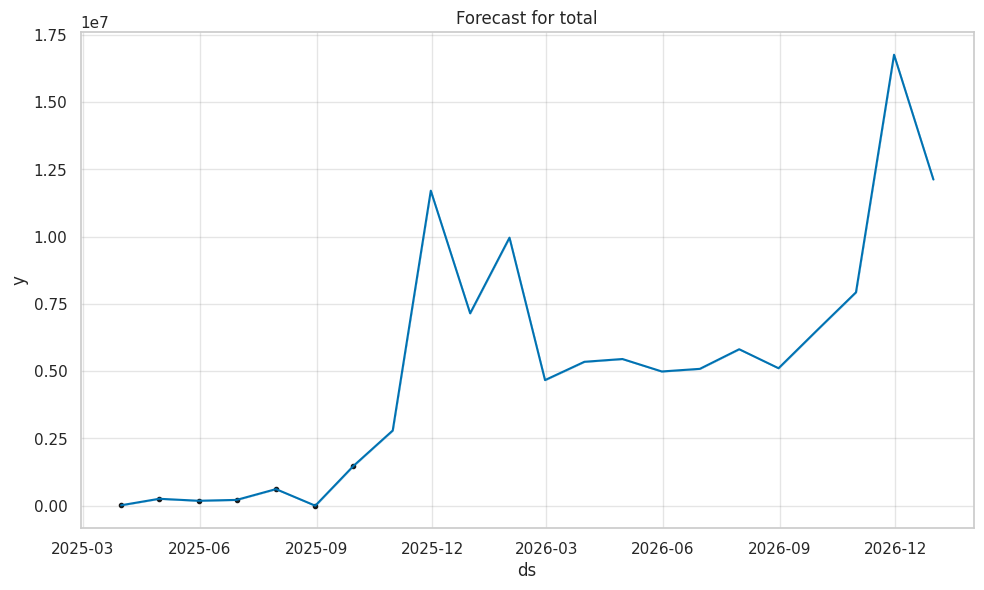


✅ Pipeline Finished Successfully.


In [33]:
if __name__ == "__main__":
    print("🚀 Starting Analysis Pipeline...")

    # 1. Detect and Load
    dataset_paths = extract_and_find_paths(ZIP_FILE_PATH, EXTRACT_DIR)

    if all(k in dataset_paths for k in ['enrol', 'bio', 'demo']):
        # 2. Load Data
        enrol_df = load_and_clean_data(dataset_paths['enrol'], 'enrol')
        bio_df = load_and_clean_data(dataset_paths['bio'], 'bio')
        demo_df = load_and_clean_data(dataset_paths['demo'], 'demo')

        # 3. Analysis & Stats
        print("\n🗺️ Classifying States...")
        state_insights = classify_states(enrol_df, bio_df, demo_df)
        print("Top 5 States by Activity:\n", state_insights.head())

        # Save Report
        state_insights.to_csv("State_Classification_Report.csv")

        # 4. Visualization
        print("\n📊 Generating Trend Plots...")
        plot_comparative_trends(enrol_df, bio_df, demo_df)

        # 5. Forecasting
        print("\n🔮 Running Forecast for Enrolment...")
        forecast_results = forecast_prophet(enrol_df, periods=12)

        # Save Forecast
        forecast_results[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("Enrolment_Forecast.csv")

        print("\n✅ Pipeline Finished Successfully.")
    else:
        print("❌ Pipeline Stopped: Missing data folders.")